<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_JAYA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [3]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [4]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [6]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [146]:
class TFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [234]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size):
    self.p_size = p_size
    self.data = []

    for i in range(p_size):
      d = {}
      d['W'] = 2*np.random.random((9*3 + 1, 1)) - 1
      model = TFLANN(d['W'])
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    print(sum([v['mse'][9] for v in self.data]))
    print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += 1.0* np.random.random((9*3 + 1, 1))* (self.data[self.best]['W'] - self.data[i]['W'])
      # t -= np.random.random((9*3 + 1, 1))* (self.data[self.worst]['W'] - self.data[i]['W'])
      model = TFLANN(t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      self.next_gen()
      print(str(self.data[self.best]['mse'][9]) + "\t" + str(self.data[self.worst]['mse'][9]))

In [241]:
optimiser = JAYATFLANN(50)
optimiser.optimise(100)
model = TFLANN(optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


13.544573702161985
[0.12603906912108423, 0.5029987045921206, 0.010168458112235278, 0.33449471520173285, 0.07457065112711624, 0.06011880486488638, 0.2027453520335094, 0.37858154099781227, 0.4276632852022936, 0.5662778108462211, 0.0896533125154987, 0.026233366858195162, 0.5369502357896923, 0.38106834298218134, 0.5812395502739045, 0.07999526519911204, 0.05904311967172528, 0.5251794271064387, 0.10090458749800683, 0.4999745771045027, 0.5846240405623201, 0.5072063589577512, 0.18546787007134977, 0.3817389468821605, 0.19226611949531178, 0.2359884379354501, 0.08833899175092486, 0.06504762387934956, 0.09739017032927764, 0.026886212735339914, 0.24846032147681185, 0.12759935506657843, 0.3975479320915279, 0.3535800613342014, 0.044738640992198125, 0.5339267755751571, 0.09333727531808954, 0.5463924393965126, 0.43239608589284917, 0.057860416071751276, 0.5811791329588809, 0.5261974520068784, 0.14141899355434182, 0.08659295730645489, 0.05961727362030267, 0.2152809666939203, 0.10000793736654075, 0.432213

In [242]:
preds[:, 0]

array([0.17573714, 0.17696869, 0.17976762, 0.18194024, 0.18399296,
       0.18143311, 0.17613287, 0.18125114, 0.18145436, 0.17116331,
       0.16456657, 0.16487781, 0.17078586, 0.17509154, 0.18377807,
       0.18969882, 0.19223169, 0.19897243, 0.20479493, 0.2100013 ,
       0.2104527 , 0.21561591, 0.2413152 , 0.26867566, 0.292202  ,
       0.35456394, 0.34312511, 0.37299634, 0.31940363, 0.33544633,
       0.33177568, 0.32664076, 0.28731143, 0.30549272, 0.31330227,
       0.36202921, 0.33629822, 0.35292692, 0.37520825, 0.38580702,
       0.39377621, 0.38118169, 0.38790951, 0.38462237, 0.34869947,
       0.34708634, 0.30177069, 0.32569935, 0.31010304, 0.31034708,
       0.28754023, 0.29424811, 0.31854692, 0.3363447 , 0.32849164,
       0.35481324, 0.35414486, 0.40755408, 0.41110106, 0.43276389,
       0.44595505, 0.44957226, 0.4833316 , 0.50180618, 0.55684431,
       0.56522282, 0.61445216, 0.67399281, 0.64064549, 0.7398442 ,
       0.5816005 , 0.63452793, 0.5595562 , 0.58948084, 0.49501

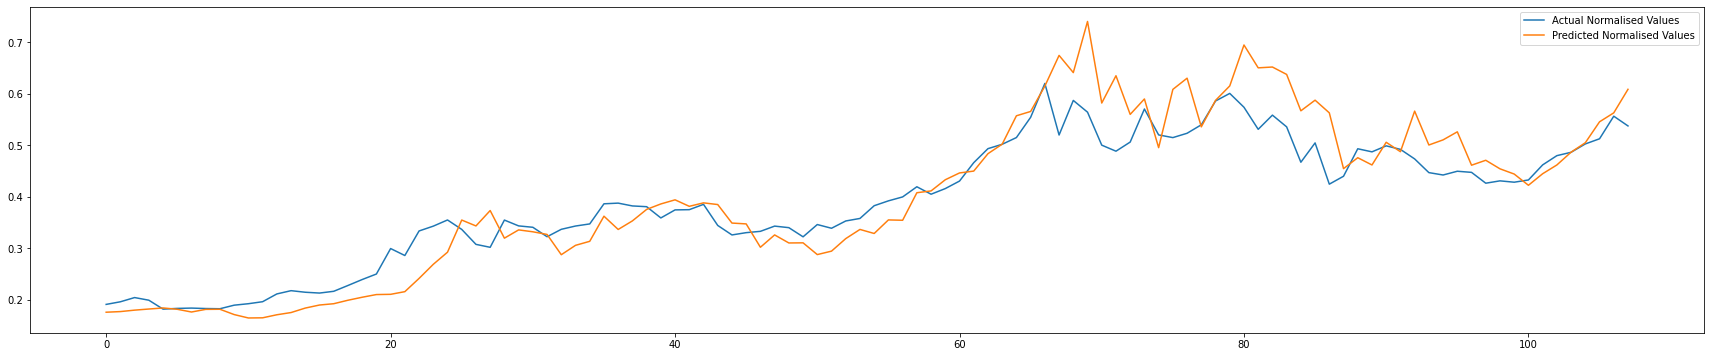

In [243]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [244]:
d1 = (data1max - data1min + 2)[0]
print(type(d1))
denormalized_preds = (preds*d1)[:,0]
# print(denormalized_preds)
denormalized_preds += (data1min + 1)[0]
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

<class 'numpy.float64'>
                       0
DATE                    
2019-04-22   5030.397244
2019-04-23   5052.245282
2019-04-24   5101.898854
2019-04-25   5140.441668
2019-04-26   5176.857487
...                  ...
2019-08-03  10539.044514
2019-08-04  10863.424633
2019-08-05  11584.085945
2019-08-06  11892.129330
2019-08-07  12702.788375

[108 rows x 1 columns]


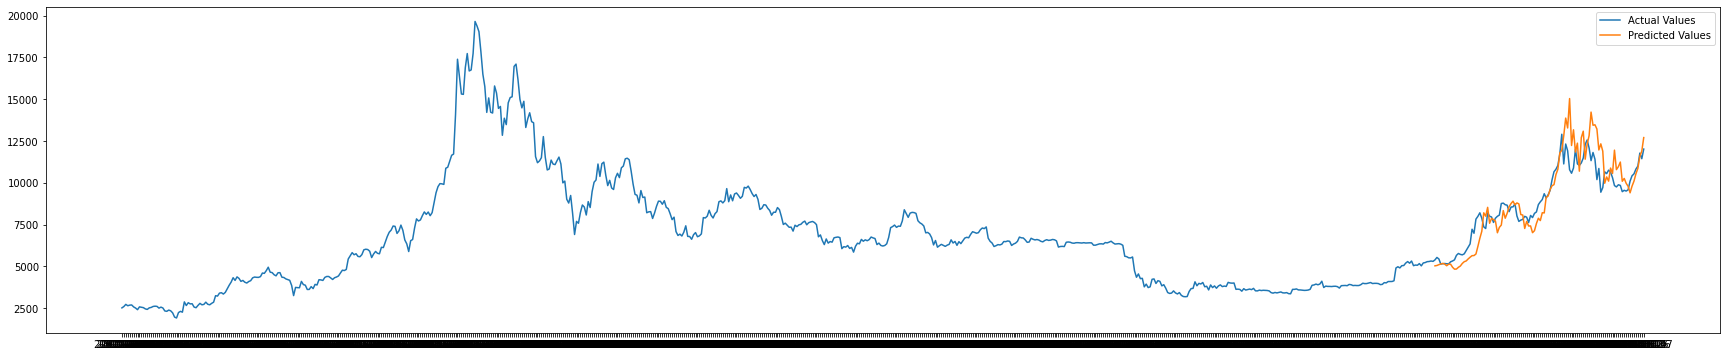

In [245]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [246]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  1198843.242235471
rmse 1094.917002441496
